https://heartbeat.comet.ml/how-to-build-a-text-classification-model-using-huggingface-transformers-and-comet-4d40236e8f84



In [49]:
import pandas as pd
import numpy as np
from transformers.integrations import TensorBoardCallback
from torch.utils.tensorboard import SummaryWriter
import torch

In [50]:
!pip install huggingface

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [51]:
!pip install huggingface transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [52]:
suffix = 'preprocessing'

In [53]:
torch.cuda.empty_cache()

In [54]:
df = pd.read_csv('filtered_data.csv')
df.info()
df = df.drop(['withheld'], axis = 1)

/home/srtoner/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,10,11,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944498 entries, 0 to 944497
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          944498 non-null  object
 1   tweet_id         944484 non-null  object
 2   tweet_text       944484 non-null  object
 3   place_id         924718 non-null  object
 4   name             924718 non-null  object
 5   full_name        924718 non-null  object
 6   country          924718 non-null  object
 7   country_code     924718 non-null  object
 8   type             924718 non-null  object
 9   username         924718 non-null  object
 10  description      791620 non-null  object
 11  user_name_field  859163 non-null  object
 12  location         801094 non-null  object
 13  withheld         51 non-null      object
 14  clean_text       857531 non-null  object
dtypes: object(15)
memory usage: 108.1+ MB


In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
country_list = ['United States', 'United Kingdom', 'Canada', 'India', 'Australia', 'Nigeria']
df= df[df['country'].isin(country_list)]
df['country'].value_counts()
df.head()

,user_id,tweet_id,tweet_text,place_id,name,full_name,country,country_code,type,username,description,user_name_field,location,clean_text
0,1051074201082388480,1637850668214960128,@Gajendr70729189 @amitsharma2704 @1shankarshar...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",Including my SAP technology business. Thank ...
1,1051074201082388480,1637818231863001090,@JatinPandyaVBNJ @1shankarsharma Indeed. Nadi...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",Indeed. Nadi Jyotish has excellent rules. N...
2,1051074201082388480,1637737394911969280,@1shankarsharma Namaste. How many years have ...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",Namaste. How many years have you spent learn...
3,1051074201082388480,1637733079002537986,An excellent example of jumping into conclusio...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",An excellent example of jumping into conclusio...
4,1051074201082388480,1637660117624836096,The want for financial security must be balanc...,5f55bb82cf16ac81,Bengaluru South,"Bengaluru South, India",India,IN,city,Pavanasoonu,Global SAP Tech. #Jyotishkatti. Spiritual cou...,Pavanasoonu,"Bengaluru, India",The want for financial security must be balanc...


In [57]:
filtered_df = df[['user_id', 'tweet_id', 'tweet_text', 'country']]
filtered_df.head()
updated_df = filtered_df.astype({'user_id':np.int64, 'tweet_id': np.int64, 'tweet_text': str, 'country':str})
updated_df.to_csv('updated_df.csv')

id2label = {0: "United States", 1: "United Kingdom", 2: "Canada", 3: "Australia", 4: "India", 5: "Nigeria"}
label2id = {"United States": 0, "United Kingdom": 1, "Canada": 2, "Australia": 3, "India": 4, "Nigeria": 5}

In [58]:
updated_df.shape

(859170, 4)

In [59]:
# sample_df = updated_df.sample(5000, random_state = 1)
sample_df = updated_df.sample(40000, random_state = 1)
sample_df.head()
sample_df['country'] = sample_df['country'].apply(lambda x: label2id[x])
sample_df.head()

,user_id,tweet_id,tweet_text,country
810865,490104241,1637289107557879808,My aunt married a white man with the last name...,0
737537,2486046872,1635484083256979456,@GovRonDeSantis It shouldn't include theologic...,0
635983,1374446305146138626,1633236299640365057,"I had my best day ever at work, today!!!!! Fou...",0
488230,100339412,1637856072521363456,@DawiLDanger My earbuds are from Big Lots (a c...,0
659364,1488755185,1637782944667320320,@CraigAFountain Same! Thanks for having me!!!,0


<AxesSubplot:xlabel='country'>

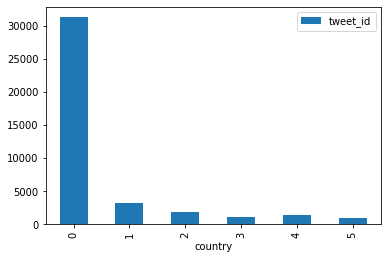

In [60]:
sample_df.groupby('country').agg('count').reset_index().plot(x='country', y = 'tweet_id', kind = 'bar')

In [61]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [62]:
from datasets import Dataset

In [120]:
test_size = 0.2
val_size = 0.2

y = sample_df['country']

X = sample_df

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size,random_state = 1, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,random_state = 1, test_size = val_size / (1 - test_size), stratify = y_train)


In [121]:
# train, validate, test = np.split(sample_df.sample(frac=1), [int(.6*len(sample_df)), int(.8*len(sample_df))])
train, validate, test = X_train, X_val, X_test

<AxesSubplot:xlabel='country'>

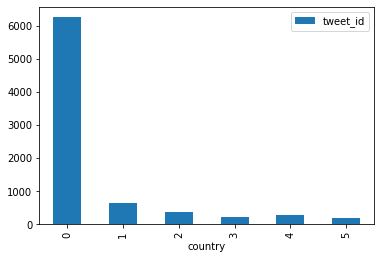

In [122]:
validate.groupby('country').agg('count').reset_index().plot(x='country', y = 'tweet_id', kind = 'bar')

In [123]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index = False)
validate.to_csv('validate.csv', index = False)

In [124]:
ds_train = Dataset.from_csv('train.csv')
ds_val = Dataset.from_csv('validate.csv')
ds_test = Dataset.from_csv('test.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/srtoner/.cache/huggingface/datasets/csv/default-34870687efc7a566/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/srtoner/.cache/huggingface/datasets/csv/default-370c75729230dca5/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/srtoner/.cache/huggingface/datasets/csv/default-61694c9b93dc18ba/0.0.0. Subsequent calls will reuse this data.


In [125]:
ds = {"train": ds_train, "validation": ds_val, "test": ds_test}

In [126]:
ds_train[0]

{'user_id': 1426246189880643591,
 'tweet_id': 1637607754805264384,
 'tweet_text': '@LotusDollaSign Nigga gon put you on a T-shirt..',
 'country': 0}

In [127]:
ds_val

Dataset({
    features: ['user_id', 'tweet_id', 'tweet_text', 'country'],
    num_rows: 8000
})

In [128]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("Twitter/twhin-bert-base", num_labels=6, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at Twitter/twhin-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-ba

In [129]:
model = model.to(device)

In [130]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, DataCollatorWithPadding
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')

In [131]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Using old preprocessing function for now, baseline results
def preprocess_function(examples):
    label = examples["country"] 
    # examples['tweet_text'].apply(preprocess)
    examples = tokenizer(preprocess(examples["tweet_text"]), truncation=True, padding="max_length", max_length=256, return_tensors='pt')
#     examples = tokenizer(examples["tweet_text"], truncation=True, padding="max_length", max_length=256, return_tensors='pt')
    
    for key in examples:
        examples[key] = examples[key].squeeze(0)#.to(device)
    examples["label"] = torch.IntTensor([label])
    examples = examples.to(device)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=['user_id', 'tweet_id', 'tweet_text', 'country'])
    ds[split].set_format('pt')

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [132]:
example = next(iter(ds['train']))

In [134]:
example

{'input_ids': tensor([    0,  1374, 65918,  1520, 31199,     6,  6126,  3884,   398,    98,
            10,   384,     9, 38184,     5,     5,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [135]:
tokenizer.decode(example['input_ids'])

'<s> @user Nigga gon put you on a T-shirt..</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [136]:
ds['train']["label"][:10]

tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [4],
        [1],
        [2],
        [0]])

In [137]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [138]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [139]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy.compute(predictions=predictions, references=labels), 
            "f1":f1_metric.compute(predictions=predictions, references=labels, average="weighted")}

In [140]:
import torch
class TwitterTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = torch.nn.functional.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [141]:
from transformers import TrainingArguments
from transformers import Trainer


# tb = TensorBoardCallback()

In [144]:
training_args = TrainingArguments(
    output_dir=f"my_awesome_model_{suffix}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = TwitterTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics,
#     callbacks = [tb]
)


In [145]:
trainer.train()

/home/srtoner/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.843800,0.852365,{'accuracy': 0.782375},{'f1': 0.6868483238656288}
2,0.850000,0.852366,{'accuracy': 0.782375},{'f1': 0.6868483238656288}


Trainer is attempting to log a value of "{'accuracy': 0.782375}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6868483238656288}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.782375}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6868483238656288}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=1500, training_loss=0.8493799641927083, metrics={'train_runtime': 826.91, 'train_samples_per_second': 58.047, 'train_steps_per_second': 1.814, 'total_flos': 6314892115968000.0, 'train_loss': 0.8493799641927083, 'epoch': 2.0})

In [85]:
trainer.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.825125}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7916006000724359}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6404178738594055,
 'eval_accuracy': {'accuracy': 0.825125},
 'eval_f1': {'f1': 0.7916006000724359},
 'eval_runtime': 37.4214,
 'eval_samples_per_second': 213.782,
 'eval_steps_per_second': 6.681,
 'epoch': 2.0}

In [86]:
predictions = trainer.predict(ds['test'])

In [103]:
predictions[0].shape

(8000, 6)

In [88]:
predictions[0]

array([[ 2.7190115 ,  0.07103778, -0.25678605, -0.9797938 , -0.7007126 ,
        -1.115655  ],
       [ 2.7583508 , -0.0410953 , -0.14792816, -0.8934755 , -0.7941069 ,
        -1.1051035 ],
       [ 3.3917513 ,  0.21092457,  0.45362034, -0.5470575 , -2.2631814 ,
        -1.925886  ],
       ...,
       [ 3.0386443 , -0.49997133, -0.10220139, -1.0925773 , -0.83279985,
        -0.863966  ],
       [ 4.1526966 , -0.39846823,  0.8654611 , -0.6102894 , -2.5102994 ,
        -2.5380177 ],
       [ 4.816143  , -0.9324344 ,  0.09976429, -1.2684848 , -2.2918658 ,
        -0.77577764]], dtype=float32)

In [89]:
from sklearn.metrics import confusion_matrix

In [90]:
predictions_array = np.argmax(predictions[0], axis = 1)

In [104]:
predictions_array.shape

(8000,)

In [105]:
labels_array = predictions[1]
labels_array.shape

(8000,)

In [106]:
confusion_matrix(labels_array, predictions_array)

array([[6102,  116,   16,    3,   12,   35],
       [ 393,  238,    1,    3,    5,   21],
       [ 314,   12,   40,    1,    1,    1],
       [ 180,   35,    3,   13,    3,    4],
       [  88,    8,    2,    0,  147,    1],
       [ 101,    2,    0,    0,    6,   93]])

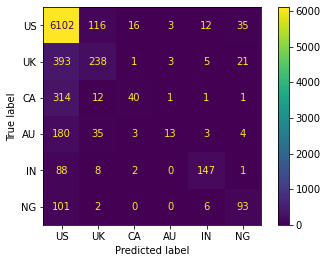

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(labels_array, predictions_array)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                    display_labels = ['US', 'UK', 'CA', 'AU', 'IN', 'NG'])
cm_display.plot();

In [95]:
trainer.save_model(f'twitter_{suffix}')

In [96]:
breadcrumbs = (ds['test'], predictions)

In [97]:
import pickle as pkl
with open (f"{suffix}_results.pkl", "wb") as f:
    pkl.dump(breadcrumbs, f)